In [1]:
# %matplotlib widget

import os
from copy import deepcopy as copy
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from astropy.stats import biweight_location, biweight_midvariance

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.core.constants import SPEC_CHANNELS
from lvmdrp.core.rss import RSS
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod, rssMethod


ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
# MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
MASTER_ARC_LAMPS = {"b": "neon_hgne_argon_xenon", "r": "neon_hgne_argon_xenon", "z": "neon_hgne_argon_xenon"}
SLITMAP = Table(drp.fibermap.data)

In [2]:
MJD = 60264
frames_table = md.get_metadata(tileid="*", mjd=MJD)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60264/raw_metadata.hdf5
[INFO]: found 783 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60264/raw_metadata.hdf5'
[INFO]: number of frames after filtering 783
[INFO]: total number of frames found 783


In [3]:
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(masters_path)

/home/mejia/Research/lvm/lvmdata/calib/60255


In [4]:
expnums = list(range(7832, 7832+12))

flats_table = frames_table.query("expnum in @expnums")
flats_table = flats_table.sort_values(["camera", "expnum"])

In [20]:
twilight_windows = {
    "b": [(3600, 3680), (3763, 3770), (3840, 3880), (3940, 3960), (3990, 4025), (4111, 4160),
          (4180, 4210), (4400, 4500), (4540, 4575), (4720, 4850), (4900, 5150), (5240, 5500), (5620, 5780)],
    "r": [(5860, 5880), (6020, 6155), (6400, 6455), (6660, 6800), (7060, 7225), (7375, 7385), (7445, 7460), (7500, 7520)],
    "z": [(7450, 7550), (7728, 7745), (7762, 7770), (7797, 7805), (7813, 7819), (7825, 7839), (7892, 7908), (7935, 7943),
          (7995, 8009), (8033, 8047), (8065, 8075), (8109, 8135), (8150, 8215), (8245, 8269), (8320, 8335),
          (8435, 8448), (8570, 8610), (8700, 8745), (9056, 9086), (9110, 9144), (9180, 9210),
          (9570, 9584), (9635, 9663), (9762, 9781)]
}

flat_analogs = flats_table.groupby(["camera"])
lamp = "twilight"

mflat_paths = []
for camera in flat_analogs.groups:
    flats = flat_analogs.get_group(camera)
    flat = flats.iloc[0].to_dict()

    print(flats.sort_values("expnum").to_string())

    arc_lamp = MASTER_ARC_LAMPS[camera[0]]
    
    # define master paths for target frames
    mpixmask_path = os.path.join(masters_path, f"lvm-mpixmask-{camera}.fits")
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{camera}.fits")
    mdark_path = os.path.join(masters_path, f"lvm-mdark-{camera}.fits")
    mpixflat_path = os.path.join(masters_path, f"lvm-mpixflat-{camera}.fits")
    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
    mwidth_path = os.path.join(masters_path, f"lvm-mwidth-{camera}.fits")
    mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
    mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
    
    # define master frame path
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mflat_{lamp}", camera=camera)
    wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{lamp}", camera=camera)
    mflat_paths.append(mflat_path)
    os.makedirs(os.path.dirname(mflat_path), exist_ok=True)
    
    # reduce individual exposures
    rsss = []
    for flat in flats.to_dict("records"):
        flat_path = path.full("lvm_raw", camspec=flat["camera"], **flat)
        pflat_path = path.full("lvm_anc", drpver=drpver, kind="p", imagetype=flat["imagetyp"], **flat)
        dflat_path = path.full("lvm_anc", drpver=drpver, kind="d", imagetype=flat["imagetyp"], **flat)
        xflat_path = path.full("lvm_anc", drpver=drpver, kind="x", imagetype=flat["imagetyp"], **flat)
        os.makedirs(os.path.dirname(xflat_path), exist_ok=True)

        # detrend frames
        if os.path.isfile(dflat_path):
            print(f"skipping {dflat_path}, file already exist")
        else:
            imageMethod.preproc_raw_frame(in_image=flat_path, out_image=pflat_path, in_mask=mpixmask_path)
            imageMethod.detrend_frame(in_image=pflat_path, out_image=dflat_path, in_bias=mbias_path, in_dark=mdark_path, in_pixelflat=mpixflat_path, in_slitmap=SLITMAP)

        # extract 1D spectra
        if os.path.isfile(xflat_path):
            print(f"skipping {xflat_path}, file already exist")
        else:
            imageMethod.extract_spectra(in_image=dflat_path, out_rss=xflat_path, in_trace=mtrace_path, in_fwhm=mwidth_path, method="optimal", parallel="auto")

        # add wavelength solution
        # rssMethod.create_pixel_table(in_rss=mflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

        # wavelength resampling
        # TODO: make sure that extrapolation near the borders are just NaNs
        # rssMethod.resample_wavelength(in_rss=xflat_path, out_rss=xflat_path, in_wave=wflat_path, method="linear", parallel="auto")

        # calculate normalized continuum
        rss = rssMethod.loadRSS(xflat_path)
        median_fiber = np.nanmedian(rss._data, axis=0)
        # TODO: change kernel to smaller one like 50 pix to account for the change of slope near the dichroic
        median_fiber = median_filter(median_fiber, size=500)

        # normalize spectra per exposure to the median fiber
        rss._data = rss._data / median_fiber
        rss._error = rss._error / median_fiber
        rsss.append(rss)
        
    # combine RSS exposures using an average
    mrss = RSS(data=np.zeros_like(rsss[0]._data), error=np.zeros_like(rsss[0]._error), mask=np.ones_like(rsss[0]._mask, dtype=bool),
               header=copy(rsss[0]._header), slitmap=copy(rsss[0]._slitmap))
    # select non-std fibers1
    fibermap =  mrss._slitmap[mrss._slitmap["spectrographid"] == int(camera[1])]
    select_allstd = fibermap["telescope"] == "Spec"
    select_nonstd = ~select_allstd
    for i, rss in enumerate(rsss):
        # coadding all non-std fibers
        mrss._data[select_nonstd] = mrss._data[select_nonstd] + rss._data[select_nonstd]
        mrss._error[select_nonstd] = np.sqrt(mrss._error[select_nonstd]**2 + rss._error[select_nonstd]**2)
        mrss._mask[select_nonstd] = mrss._mask[select_nonstd] & rss._mask[select_nonstd]
        
        # put std fibers in the right position
        fiber_id = f"P1-{i+1}"
        idx = np.where(fibermap["orig_ifulabel"].value == fiber_id)
        mrss._data[idx] = rss._data[idx]
        mrss._error[idx] = rss._error[idx]
        mrss._mask[idx] = mrss._mask[idx] & rss._mask[idx]
        mrss._header.update(rss._header["STD*"])
    
    # compute average of non-std fibers
    mrss._data[select_nonstd] = mrss._data[select_nonstd] / len(rsss)
    mrss._error[select_nonstd] = mrss._error[select_nonstd] / np.sqrt(len(rsss))

    mrss.writeFitsData(mflat_path)

    # add wavelength solution
    # rssMethod.create_pixel_table(in_rss=mflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
78     s    1111  60264  60264     flat  sp1     b1    7832    181.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007832.fits
606    s    1111  60264  60264     flat  sp1     b1    7833     57.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007833.fits
512    s    1111  60264  60264     flat  sp1     b1    7834     29.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007834.fits
614    s    1111  60264  60264     flat  sp1     b1    7835     18.0  False  False    False  False  False  False   False  excellent     0      1       0        0  sdR-s-b1-00007835.fits
585    s    1111  60264  60264     flat  sp1     b1    7836     12.0  

In [21]:

def create_twilight_flat(in_rsss, out_rsss, median_box=50, wave_range=None, clip_sigma=None, poly_deg=3, continuum_windows=[], display_plots=True):

    # stack twilight flats
    rss = RSS()
    rss.loadFitsData(in_rsss[0])
    rsss = [rssMethod.loadRSS(in_rss) for in_rss in in_rsss]
    flat = rss.stackRSS(rsss, axis=1)

    # copy original twilight flat
    orig_flat = copy(flat)

    # useful metadata
    camera = rss._header["CCD"]
    unit = rss._header["BUNIT"]

    # update mask for invalid values
    flat._mask |= np.isnan(flat._data) | np.isinf(flat._data)

    # mask pixels outside given wavelength range
    # TODO: no need because this is rectified
    if wave_range is not None:
        iwave, fwave = wave_range
        flat._mask |= ~((iwave <= flat._wave) & (flat._wave <= fwave))
        flat._data[flat._mask] = np.nan
    
    # interpolate bad pixels in each fiber
    flat.interpolate_data(axis="X", reset_mask=False)

    # remove high-frequency features and update mask
    if median_box is not None:
        flat._data = median_filter(flat._data, (1, median_box))
        flat._mask |= np.isnan(flat._data)

    # sigma clipping
    if clip_sigma is not None:
        if isinstance(clip_sigma, (int, float)):
            low, high = clip_sigma, clip_sigma
        elif isinstance(clip_sigma, (list, tuple)) and len(clip_sigma) == 2:
            low, high = clip_sigma
        else:
            raise ValueError("clip_sigma must be a number or a list/tuple of two numbers")
        
        ave = biweight_location(flat._data, axis=1, ignore_nan=True)
        std = biweight_midvariance(flat._data, axis=1, ignore_nan=True)
        mask = ~flat._mask | (np.abs(flat._data - ave[:, None]) < low * std[:, None]) | (np.abs(flat._data - ave[:, None]) > high * std[:, None])
        flat._data[~mask] = np.nan
        flat._mask[~mask] = True
        flat.interpolate_data(axis="X")

    # mask bad fibers
    # fibermap = flat._slitmap[flat._slitmap["spectrographid"] == int(camera[1])]
    # select_bad = fibermap["fibstatus"] != 0
    # flat._mask[select_bad] = True
    # flat._data[select_bad] = 0.0

    # TODO: replace this block by the continuum fitting going above the absorption lines
    # mask data outside twilight windows
    if continuum_windows:
        mask = np.ones_like(flat._data, dtype=bool)
        for window in continuum_windows:
            mask &= ~((window[0] <= flat._wave) & (flat._wave <= window[1]))
        flat._mask |= mask
    # fit polynomial and/or interpolate bad fibers
    if poly_deg is not None:
        flat.fit_polynomial(deg=poly_deg)
        flat.interpolate_coeffs()
    else:
        flat.interpolate_data(axis="Y")
    
    # plot flatfielded twilight flat
    if display_plots:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)
        plt.ylim(0, 1.5)
        axes[0].set_title(f"Twilight flat for channel = {camera[0]}", loc="left")
        for window in continuum_windows:
            axes[0].axvspan(*window, color="k", alpha=0.5)
            axes[1].axvspan(*window, color="k", alpha=0.5)
            axes[2].axvspan(*window, color="k", alpha=0.5)
        axes[0].step(orig_flat._wave.T, orig_flat._data.T, lw=1, color="k", alpha=0.1)
        axes[1].plot(flat._wave.T, flat._data.T, lw=1.5, color="tab:blue", alpha=0.1)
        axes[2].step(orig_flat._wave.T, (orig_flat._data / flat._data).T, lw=1, color="tab:red", alpha=0.1)
        axes[2].set_xlabel("Wavelength (Angstrom)")
        axes[0].set_ylabel(f"Counts ({unit})")
        axes[1].set_ylabel("Relative counts")
        axes[2].set_ylabel(f"Counts ({unit})")
        plt.show()

    # split RSS into individual spectrographs
    for i, flat_spec in enumerate(flat.splitRSS(axis=1, parts=len(in_rsss))):
        # TODO: resample back to the native wavelength grid
        
        flat_spec.writeFitsData(out_rsss[i])

    return flat

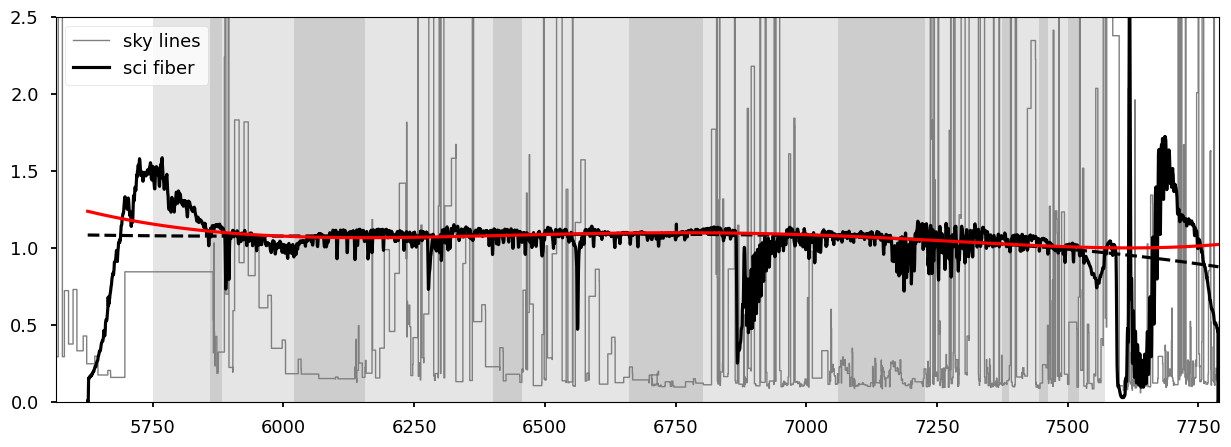

In [22]:
channel = "r"
wflat_paths = []
mfiberflat_paths = []
for specid in [1,2,3]:

    iwave, fwave = SPEC_CHANNELS[channel]
    camera = f"{channel}{specid}"

    wflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{lamp}", camera=camera))
    mfiberflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mfiberflat_{lamp}", camera=camera))

# create_twilight_flat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, wave_range=(iwave, fwave), median_box=400, poly_deg=4, continuum_windows=twilight_windows[channel], display_plots=True)


p = os.path.join(os.getenv('LVMCORE_DIR'), 'etc', 'UVES_sky_lines.txt')
txt = np.genfromtxt(p)
skyw, skyf = txt[:,1], txt[:,4]

camera = "r2"
wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{lamp}", camera=camera)
mfiberflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mfiberflat_{lamp}", camera=camera)

x = rssMethod.loadRSS(wflat_path)
f = rssMethod.loadRSS(mfiberflat_path)
# fibermap = f._slitmap[f._slitmap["spectrographid"] == int(camera[1])]
# select = fibermap["telescope"] == "Spec"
# colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# plt.figure(figsize=(20,5))
# for i, fiberid in enumerate(fibermap[select]["orig_ifulabel"].value):
#     if fiberid.startswith("P2"):
#         continue
#     idx = np.where(fibermap["orig_ifulabel"].value == fiberid)
#     color = colors[i % len(colors)]
#     plt.plot(x._wave[idx].flatten(), x._data[idx].flatten(), "-", color=color, label=fiberid)
#     plt.plot(f._wave[idx].flatten(), f._data[idx].flatten(), "--", color=color)

idx = [0, 100, 300, 500, 600]
idx = [300]

plt.figure(figsize=(15,5))
plt.step(skyw, skyf, "-", color="0.5", lw=1, label="sky lines")
plt.axvspan(iwave, fwave, color="k", alpha=0.1)
plt.plot(x._wave[idx].T, x._data[idx].T, "-", label="sci fiber", color="k")
plt.plot(f._wave[idx].T, f._data[idx].T, "--", color="k")
plt.xlim(x._wave.min(), x._wave.max())
plt.ylim(0, 2.5)
plt.legend()

for window in twilight_windows[camera[0]]:
    plt.axvspan(*window, color="k", alpha=0.1)

# # smooth high-frequency features
x._data = median_filter(x._data, (1, 400))
x._mask |= np.isnan(x._data)

# mask data outside twilight windows
mask = np.ones_like(x._data, dtype=bool)
for window in twilight_windows[camera[0]]:
    mask &= ~((window[0] <= f._wave) & (f._wave <= window[1]))
x._mask |= mask

# fit polynomial
x.fit_polynomial(deg=4)
# x.interpolate_coeffs()
plt.plot(x._wave[idx].T, x._data[idx].T, "-", label="continuum", color="r")

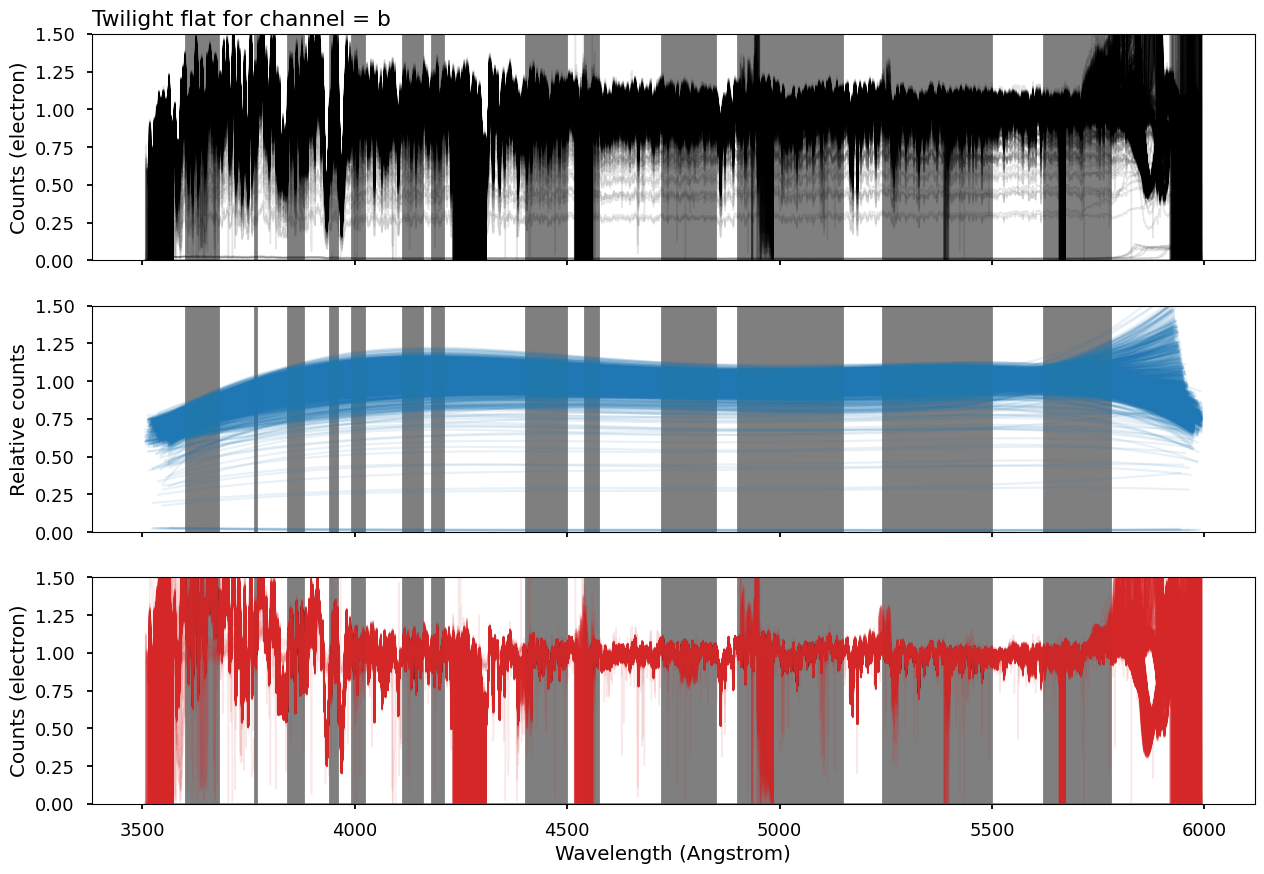

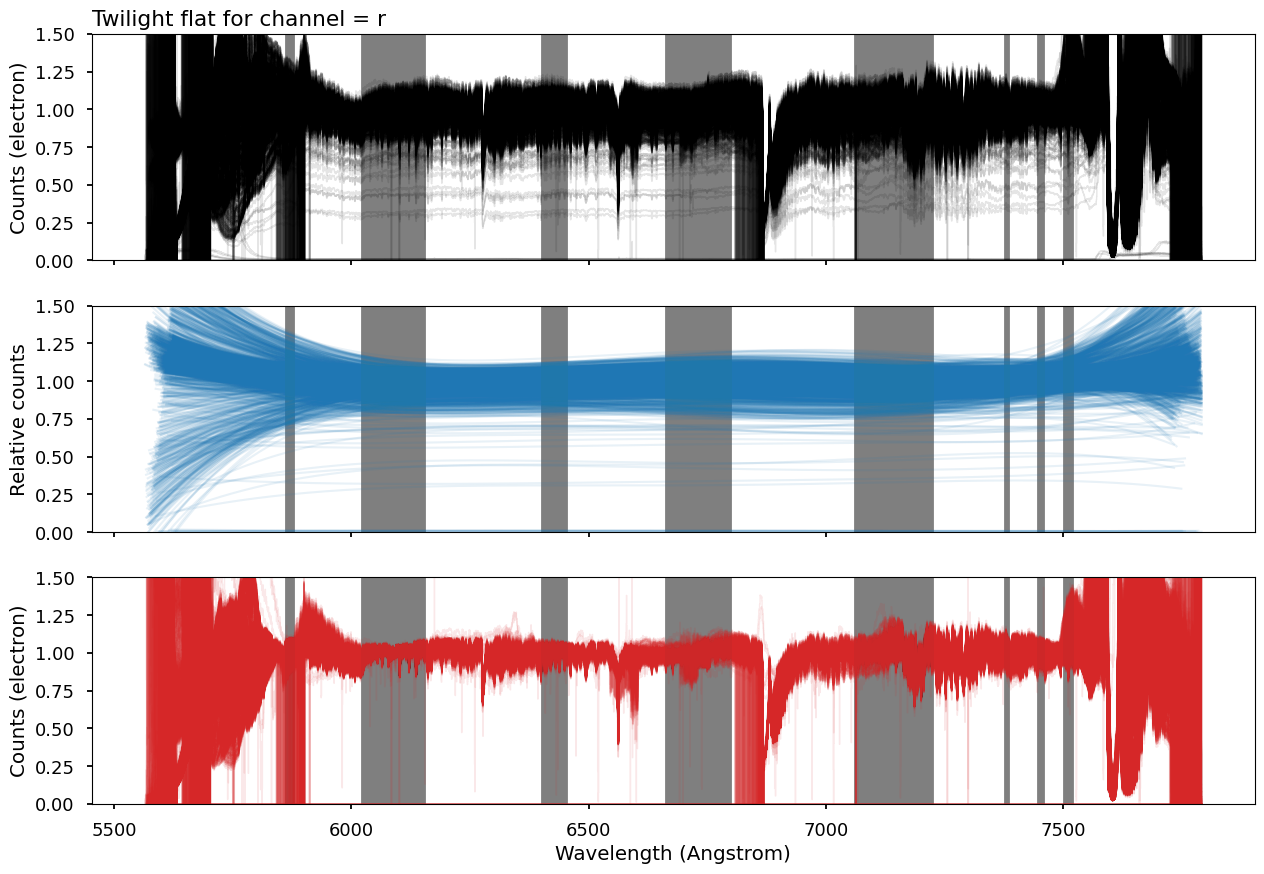

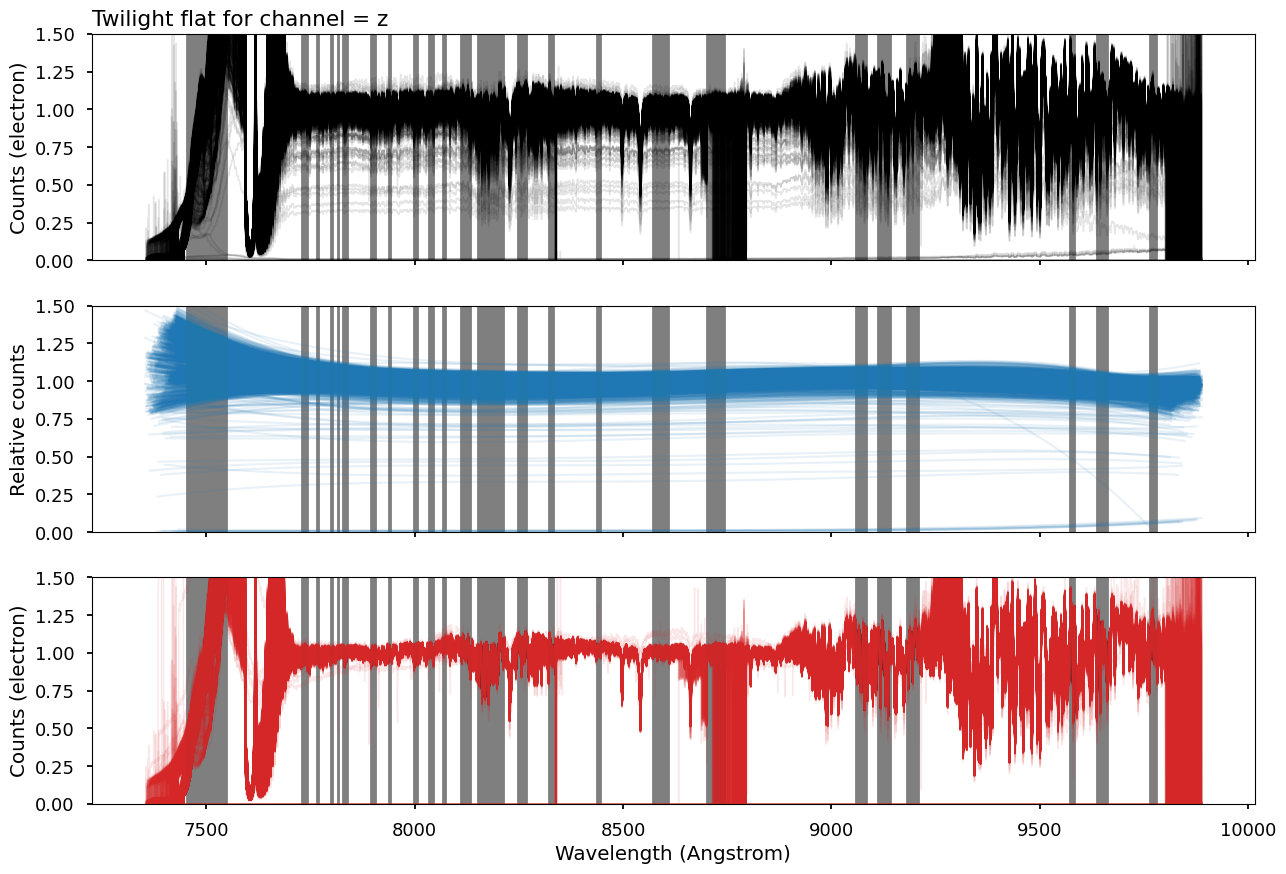

In [26]:
for channel in "brz":
    wflat_paths = []
    mfiberflat_paths = []
    for specid in [1,2,3]:

        iwave, fwave = SPEC_CHANNELS[channel]
        camera = f"{channel}{specid}"

        wflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{lamp}", camera=camera))
        mfiberflat_paths.append(path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mfiberflat_{lamp}", camera=camera))

    create_twilight_flat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, wave_range=(iwave, fwave), median_box=200, poly_deg=4,
                         continuum_windows=twilight_windows[channel], display_plots=True)

In [9]:
# from sdss_access  import Access


# a = Access(release='sdsswork')
# a.remote()
# for expnum in expnums:
#     a.add('lvm_raw', hemi="s", mjd=MJD, tileid='*', camspec="*", expnum=expnum)
# a.set_stream()
# a.commit()